## Загрузка библиотек и датасетов, очистка и подготовка данных

(если вам интересно только исследование, раскрывать этот раздел не нужно - просто запустите ячейки)

In [255]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import re

###  Очистка и подготовка датасета резюме

In [256]:
dfr = pd.read_csv('resume_list_test.csv')

# drop trash columns and full duplicates, rename columns
dfr = dfr.drop(columns=['Unnamed: 0']).drop_duplicates()
dfr = dfr.rename(columns={'skills-content': 'skills', 
                          'work_text':'work', 
                          'tags_list': 'tags', 
                          'tags_list_len': 'ntags', 
                          'gender': 'male'}) 

# check for resume language: 1 if made in english, 0 otherwise
dfr['english'] = dfr.apply(func=(lambda x: 1 if 'ale' in x['male'] else 0), axis=1) 

# convert age to int, cutting to first two symbols
dfr.age = dfr.age.transform(lambda x: int(x[:2])) 

# drop nonbinary people (only 3 of them), encode genders as "is male?"
dfr = dfr.drop(dfr[dfr.male=='Пол не указан'].index, inplace=False)
dfr.male = dfr.male.transform(lambda x: 1 if x in 'Male Мужчина' else 0) 

# fetch currency and make it standartized, insert column near to salary
dfr.insert(2 ,'currency', dfr.salary.transform(lambda x: re.sub("[\d ]", "", x.replace('\u2009', ''))))
dfr.currency = dfr.currency.replace('руб.', 'RUB')

# convert salary to int, drop the most obvious outliers
dfr.salary = dfr.salary.transform(lambda x: int(re.sub("\D", "", x.replace('\u2009', ''))))
dfr = dfr.drop(index=dfr.loc[dfr.currency=='RUB'].loc[dfr.salary>=2000000].index)

# if experience is under 12 months, round it up to 1 year
# floor all other values to years only, convert non-numerical values to nans
dfr.loc[(dfr.experience.str.extract('^[^\d]+(\d+ мес|\d+ mon)').dropna().index), 'experience'] = 'Опыт работы 1 год'
dfr.experience = dfr.experience.transform(lambda x: (re.findall("\d+", x)+[np.nan])[0]).astype(dtype='float')

# drop rows with no work description (only 2 of them) and duplicates 
# reset index after all removals
dfr = dfr.dropna(subset='work')
dfr = dfr.drop_duplicates(subset=['work']).reset_index(drop=True)

# sort tags in alphabetical order
# (it wasn't THAT helpful, but anyway)
sort_tags = lambda st: "['" + "', '".join(sorted(st.strip("[']").split("', '"))) + "']"
dfr.tags = dfr.tags.transform(sort_tags)

# sort specializations in alphabetical order
# (though this thing WAS helpful: 400 uniques instead of 600)
sort_spec = lambda ss:"['" + "', '".join(sorted(re.sub("^\w+:\n", "", ss).split("\n"))) + "']"
dfr.specialization = dfr.specialization.fillna('').transform(sort_spec)

# count specializations, make new variable
count_vals = lambda cv: 0 if cv=="['']" else len(cv.strip("[']").split("', '"))
dfr.insert(list(dfr.columns).index('specialization')+1, 'nspecs', dfr.specialization.transform(count_vals))

# does candidate live in one of Russian capitals (Moscow, Saint-Petersburg)?
dfr.insert(list(dfr.columns).index('city')+1, 'capital', dfr.city.isin(['Moscow', 'Москва', 'Saint Petersburg', 'Санкт-Петербург']).astype('int'))

# /IMPORTANT/ need to find and add english equivalents here (but i'm too tired for this)
# there're 3 most popular specializations, what if we separate their combinations?
ps = ['Директор по маркетингу и PR (CMO)', 'Менеджер по маркетингу, интернет-маркетолог', 'Руководитель отдела маркетинга и рекламы']
pop_spec=[str(ps)]

for i in range(len(ps)): # this solution is AWFUL, I know.
    pscopy = ps[:]
    del pscopy[i]
    pop_spec.append(str(pscopy))
    pop_spec.append(f"['{ps[i]}']")

dfr.insert(list(dfr.columns).index('nspecs')+1, 'popular_specs', dfr.specialization.isin(pop_spec).astype('int'))

In [257]:
### trim dataset for simpler analysis:
# drop nans in experience, categorize
dfres = dfr.copy().dropna(subset='experience')
dfres.experience = pd.cut(dfres.experience, bins=[0,4,9,14,19,100],
                          labels=['1-4', '5-9', '10-14', '15-19', '20+'])

# categorize ages
dfres.age = pd.cut(dfres.age, bins=[15,24,29,34,39,44,49,54,100],
                          labels=['<24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', '55+'])

# leave only RUB salary, delete outliers, cut zeros
dfres = dfres[(dfres.currency == 'RUB') & (dfres.salary < 800_000)]
dfres.salary = dfres.salary*0.001

dfres = dfres.reset_index(drop=True)

### Очистка и подготовка датасета вакансий

In [258]:
dfv = pd.read_csv('vacancy_list_test.csv')

# drop trash columns and full duplicates, rename columns
dfv = dfv.drop(columns=['Unnamed: 0']).drop_duplicates()
dfv = dfv.rename(columns={'tags_list': 'tags', 
                          'tags_list_len': 'ntags',
                          'city2':'address'}) 
    
# handle 2 cases: drop row with unspecified salary, try to guess unknown tax regime 
dfv = dfv.drop(dfv.loc[dfv.salary=='з/п не указана'].index)
taxes_specified = dfv.salary.str.endswith('до вычета налогов') + dfv.salary.str.endswith('на руки')
dfv.salary = dfv.salary.where(taxes_specified, lambda x: x+' до вычета налогов')

# make new variable for tax regime: 1 if sum is taxed, 0 otherwise
dfv['taxed'] = dfv.salary.str.endswith('до вычета налогов').transform(lambda x: 1 if x else 0)

# split salary in two variables: 'salfrom' and 'salto'
# transform unknown numbers to nans
dfv['salfrom'] = dfv.salary.str.findall('от [\d ]+').apply(lambda x: float(re.sub('[от ]', '', str((x +[0])[0]))))
dfv['salto'] = dfv.salary.str.findall('до [\d ]+').apply(lambda x: float(re.sub('[до ]', '', str((x +[0])[0]))))
dfv.loc[:, ['salfrom', 'salto']] = dfv.loc[:, ['salfrom', 'salto']].replace(0.0, np.nan)

# fetch currency and make it standartized
dfv['currency'] = dfv.salary.apply(lambda x: (x.removesuffix(' на руки').removesuffix(' до вычета налогов')[-4:]))
dfv.currency = dfv.currency.apply(lambda x: x.strip().strip('.').replace('руб', 'RUB').replace('сум', 'UZS'))

# found strange salary, I bet it's mistape, must be RUB instead of UZS
uzs_strange_index = dfv.loc[dfv.currency=='UZS'].loc[dfv.salfrom + dfv.salto < 2000000].index # 2M UZS is very small amount, just around 14K RUB
dfv.loc[uzs_strange_index, 'currency'] = 'RUB'

# some salaries obviously have to be multiplied by 1000
mask_salfrom = ~((dfv.currency == 'RUB') & (dfv.salfrom < 1000))
mask_salto = ~((dfv.currency == 'RUB') & (dfv.salto < 1000))
dfv.salfrom = dfv.salfrom.where(mask_salfrom, lambda x: x*1000)
dfv.salto = dfv.salto.where(mask_salto, lambda x: x*1000)

# find Moscow in variables city and city2, then merge all values in new variable
moscow_in_city2 = dfv.address.fillna('неизвестно').str.contains('Москва,').transform(lambda x: 'Москва' if x else 'Регион')
dfv['mow'] = dfv.city.fillna(moscow_in_city2).str.contains('Москва').transform(lambda x: 1 if x else 0)

#sort tags (wasn't very helpful)
dfv.tags = dfv.tags.transform(sort_tags)

# drop unused column and duplicates, reset index
dfv = dfv.drop(columns=['salary'])
dfv = dfv.drop_duplicates(subset=['description', 'city', 'address']).reset_index(drop=True)

In [259]:
### trim dataset for simpler analysis:
# leave only salary in RUB with known lower border
# upper border lower than 800 k
# cut zeros
dfvac = dfv[(dfv.currency=='RUB')].drop(dfv[dfv.salto >= 800_000].index).copy().dropna(subset=['salfrom']).reset_index(drop=True)
dfvac.salfrom = dfvac.salfrom*0.001
dfvac.salto = dfvac.salto*0.001

#drop unused variables
dfvac = dfvac.drop(columns=['address', 'city', 'currency'])
 
# treat experience as ordinal
dfvac.experience = dfvac.experience.astype(pd.api.types.CategoricalDtype(    categories=["не требуется", "1–3 года", "3–6 лет", "более 6 лет"], ordered=True))

dfvac.ntags = pd.cut(dfvac.ntags, bins=[0,1,4,9,14,19,24,40], include_lowest=True, labels=['0', '1-4', '5-9', '10-14', '15-19', '20-24', '25+'])

## Исследование резюме

В датасете представлены резюме, (предположительно, с сайта hh.ru). Это анкеты директоров по маркетингу, рекламе и тому подобным направлениям.

Для исследования были отфильтрованы резюме с ожидаемой зарплатой в рублях, не выше 800 т.р., без пустых значений опыта работы (вероятно, это результат ошибки парсинга, либо устройства самой платформы). Значения возраста и опыта работы были приведены к категориям по 5-10 лет.

Версия для анализа содержит меньше строк: 2826.

### 1. Главная разделительная черта

Основную часть исследования резюме занимает выделение различных групп кандидатов.

И довольно быстро я нашёл один параметр, который является разделительной чертой почти во всём. И это - факт расположения в одной из двух столиц России.

Далее в графиках Столицами обозначаются Москва и Питер, а Регионами - все остальные города.

На этом графике видно огромное расслоение зарплатных ожиданий.

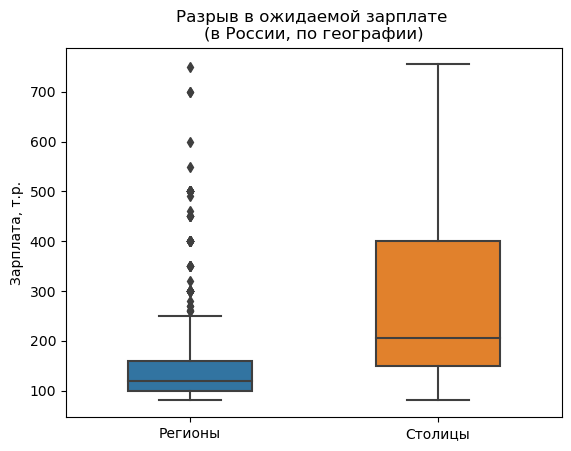

<Figure size 640x480 with 0 Axes>

In [260]:
sns.boxplot(data=dfres, x='capital', y='salary', width=0.5)

plt.title('Разрыв в ожидаемой зарплате \n(в России, по географии)')
plt.ylabel('Зарплата, т.р.')
plt.xticks(ticks=[0,1], labels=["Регионы", "Столицы"])
plt.xlabel('')

plt.show()
plt.clf()

### 2. Как распределены мужчины и женщины по России?

Хотя в целом датасет сбалансирован по половому признаку, между регионами и столицами есть некоторая разница.

Если в столицах соотношение половых групп равное, то  в регионах больше представлены женщины.

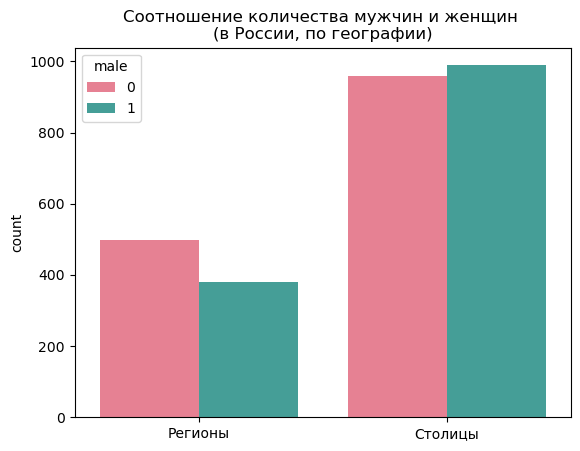

<Figure size 640x480 with 0 Axes>

In [261]:
sns.countplot(data=dfres, x='capital', hue='male', palette ='husl')

plt.title('Соотношение количества мужчин и женщин \n(в России, по географии)')
plt.xticks(ticks=[0,1], labels=["Регионы", "Столицы"])
plt.xlabel('')
plt.show()
plt.clf()

### 3. Ожидаемые зарплаты мужчин и женщин

Разница между зарплатными ожиданиями мужчин и женщин проявляется почти во всех сравнениях. Однако даже здесь разница "столицы/регионы" является более значимой: столичные женщины просят больше, чем мужчины из регионов.

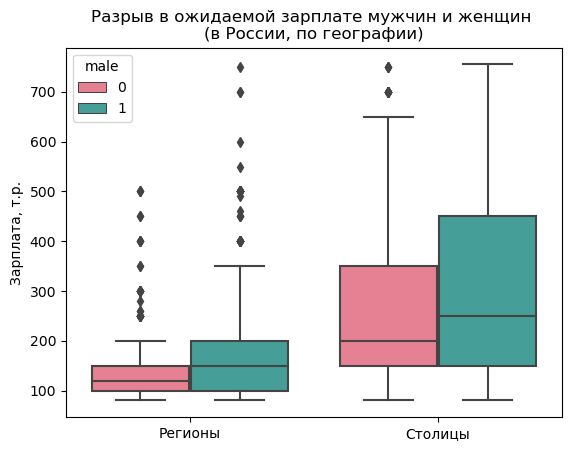

<Figure size 640x480 with 0 Axes>

In [262]:
sns.boxplot(data=dfres, x='capital', y='salary', hue='male', palette='husl')

plt.title('Разрыв в ожидаемой зарплате мужчин и женщин \n(в России, по географии)')
plt.ylabel('Зарплата, т.р.')
plt.xticks(ticks=[0,1], labels=["Регионы", "Столицы"])
plt.xlabel('')

plt.show()
plt.clf()

### 4. Резюме, составленные на английском

Резюме, которые помечены в системе, как англоязычные, запрашивают значительно более высокие зарплаты, чем любая другая группа. В регионах таких резюме почти не нашлось, но даже внутри группы столичных резюме они значительно выделяются

>*Логика обозначения резюме как англоязычного, до конца не ясна: в датасете есть анкеты, которые явно составлены как англоязычные, но в системе hh.ru их язык - русский.*

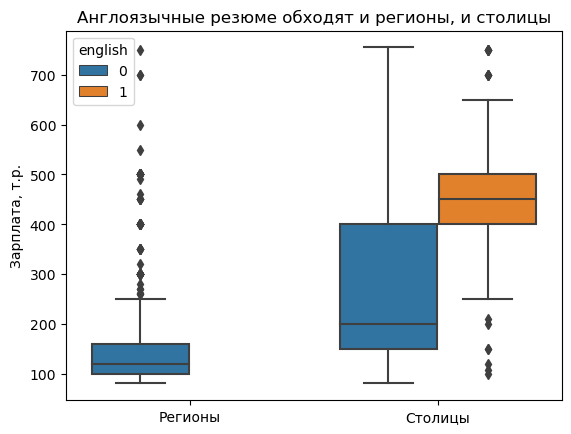

<Figure size 640x480 with 0 Axes>

In [263]:

sns.boxplot(data=dfres[~((dfres.english==1)&(dfres.capital==0))], x='capital', y='salary', hue='english')
plt.title('Англоязычные резюме обходят и регионы, и столицы')

plt.ylabel('Зарплата, т.р.')
plt.xticks(ticks=[0,1], labels=["Регионы", "Столицы"])
plt.xlabel('')
# Tried to make legend with custom labels ('RUS' and 'ENG'). Failed.

plt.show()
plt.clf()

### 5. Рост зарплатных ожиданий приходит с опытом (не у всех)

Значительная разница между столицами и регионами:

В регионах ожидаемая з/п начинает расти только после 20 лет карьеры, в то время как у столичных управленцев рост ожиданий начинается сразу же.

Рост происходит не у всей группы, а только у некоторой части, что растягивает дисперсию (видимо, опыт здесь - не единственный предиктор)

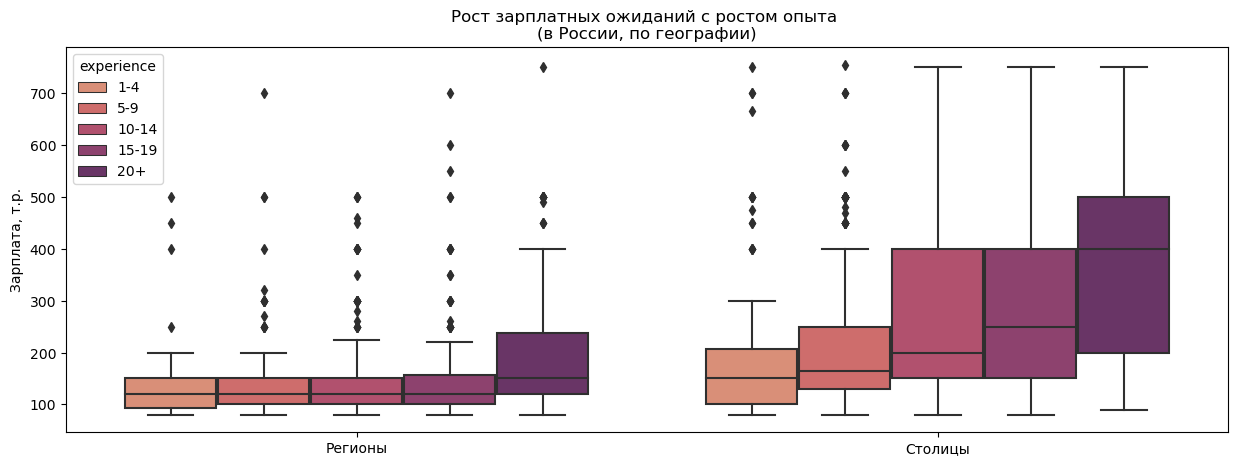

<Figure size 640x480 with 0 Axes>

In [264]:
plt.figure(figsize=(15, 5))
plt.title('Рост зарплатных ожиданий с ростом опыта \n(в России, по географии)')
sns.boxplot(data=dfres, x='capital', y='salary', hue='experience', palette='flare')

plt.ylabel('Зарплата, т.р.')
plt.xticks(ticks=[0,1], labels=["Регионы", "Столицы"])
plt.xlabel('')

plt.show()
plt.clf()

Копнём глубже в сторону столичных управленцев: их график выглядит как-то неоднородно.

Основные искажения здесь вносят англоязычные резюме: их распределение совсем непохоже на русскоязычные.

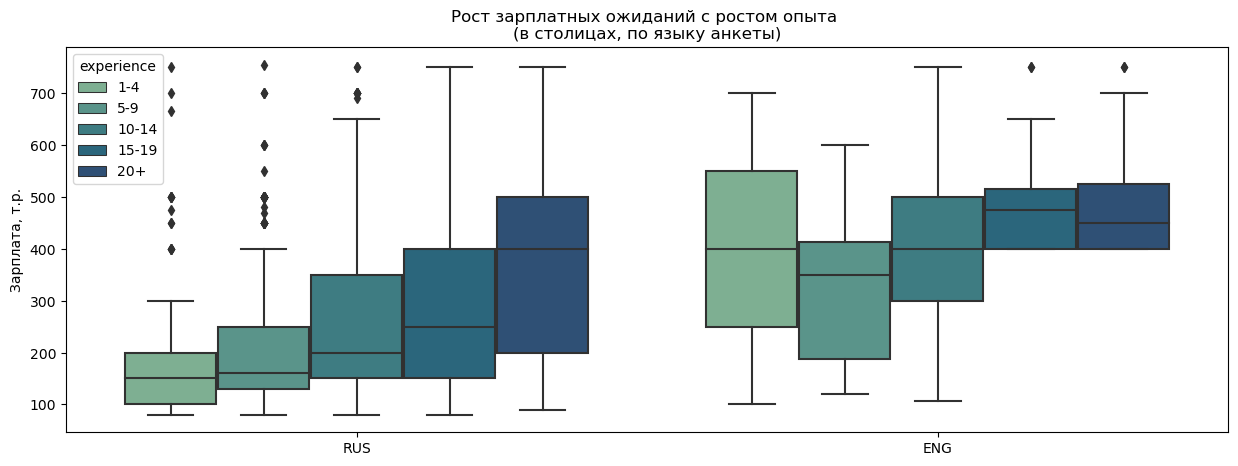

<Figure size 640x480 with 0 Axes>

In [265]:
plt.figure(figsize=(15, 5))
plt.title('Рост зарплатных ожиданий с ростом опыта \n(в столицах, по языку анкеты)')
sns.boxplot(data=dfres[dfres.capital==1], x='english', y='salary', hue='experience', palette='crest')

plt.ylabel('Зарплата, т.р.')
plt.xticks(ticks=[0,1], labels=["RUS", "ENG"])
plt.xlabel('')

plt.show()
plt.clf()

### Прочие находки

Я заметил несколько вещей, которые (на мой взгляд) не дают важных инсайтов, но всё ещё могут быть интересны.

1. Какое-то неадекватно большое количество анкет содержат 0, 1 либо 30 тегов (30 - максимально возможное число). При этом серьёзного влияния на какие-либо показатели это не имеет.

2. Большинство анкет имеют одну, две, либо все из трёх специализаций:
*   Директор по маркетингу и PR (CMO)
*   Менеджер по маркетингу,интернет-маркетолог
*   Руководитель отдела маркетинга и рекламы

>*Потенциально, принадлежность к этому классу тоже может быть серёзным разделителем, однако требуется дополнительное изучение.*

3. Любовь к круглым числам: пять самых частых значений зарплаты кратны 50 тысячам. Впрочем, это совершенно естественно для такой сферы. Интересно сравнить ожидаемую зарплату с предлагаемой.

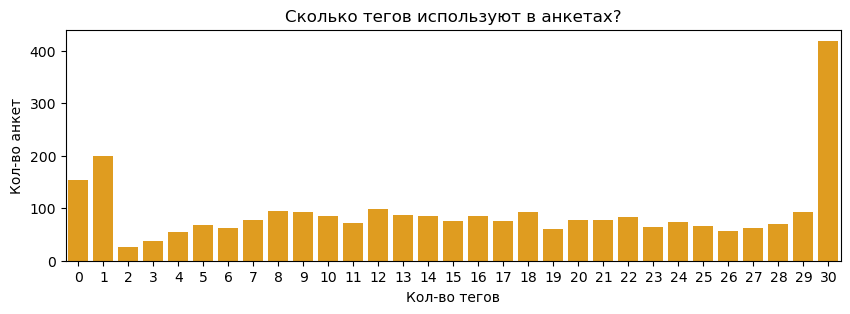

<Figure size 640x480 with 0 Axes>

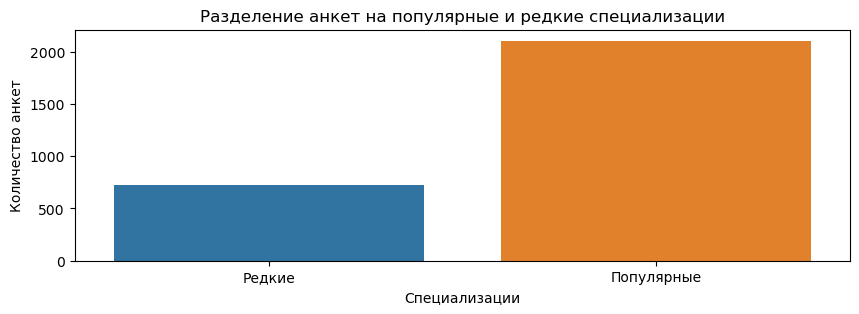

<Figure size 640x480 with 0 Axes>

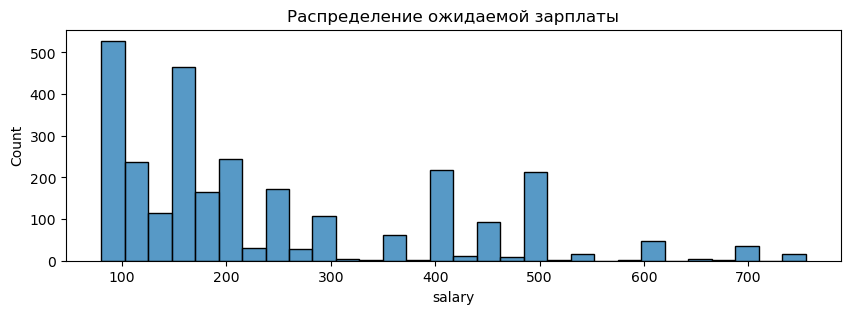

<Figure size 640x480 with 0 Axes>

In [266]:
### 1
plt.figure(figsize=(10, 3))
plt.title('Сколько тегов используют в анкетах?')
sns.countplot(data=dfres, x='ntags', color='orange')

plt.ylabel('Кол-во анкет')
# plt.xticks(ticks=[0,1], labels=["Регионы", "Столицы"])
plt.xlabel('Кол-во тегов')

plt.show()
plt.clf()


### 2
plt.figure(figsize=(10, 3))
plt.title('Разделение анкет на популярные и редкие специализации')
sns.countplot(data=dfres, x='popular_specs')

plt.ylabel('Количество анкет')
plt.xlabel('Специализации')
plt.xticks(ticks=[0,1], labels=["Редкие", "Популярные"])

plt.show()
plt.clf()


### 3
plt.figure(figsize=(10, 3))
plt.title('Распределение ожидаемой зарплаты')
sns.histplot(data=dfres, x='salary', bins=30)

plt.show()
plt.clf()

## Исследование вакансий

Сообщу честно: на изучение датасета вакансий я оставил слишком мало времени, к тому же в нём куда меньше интересных переменных для категоризации.

Все отклонения, которые я нашёл, были либо незначительными, либо очевидными:

- Больше опыт - больше платят
- Вакансии с 25 и более тегами предлагают зарплатный потолок немного выше, чем остальные
- Очень много вакансий имеют либо 0, либо 5 тегов
- Зарплата "на руки" немного ниже зарплаты "до вычета налогов"
- В Москве минимальные зарплаты могут быть даже ниже не-московских (что удивительно, но не слишком значимо из-за малого числа не-московских вакансий)

Приводить графику здесь не вижу большого смысла, извините :/

## Общие выводы


Главные факторы, разделяющие соискателей на однородные группы - это пол, язык резюме, география (регионы/столицы). Причём география влияет даже больше, чем пол. Конкретные цифры и сравнения были выше, здесь же хочется сказать более абстрактно

Приведённые данные показывают, что на рынке вакансий существует достатояно чёткое разделение на сегменты. Вероятно, каждый из этих сегментов устроен по каким-то своим принципам, и я вижу здесь два практически примених вывода:

- При ведении переговоров и хантинге таких специалистов необходмио применять разные аргументы и методы
- Специалисты из этих регионов могут иметь нераскрытый потенциал. Возможно, взаимодействие двух рынков откроет новые возможности.

**Дальнейшее изучение датасетов:**

Если бы я имел больше времени, следующим шагом я бы попробовал как-то проанализировать теги: 
- Какие теги требуют больше опыта? 
- Какиие приносят больше денег?
- Как они соотносятся с тегами из датасета резюме? 

Если бы я имел больше навыков, то интерес представляли бы названия, описания и теги - словом, это задача для машинного обучения:
- Какую специализацию требуют в вакансии? Местами это совсем не директорские позиции.
- Как эти специализации соотносятся с резюме?
- Какие теги привязаны к специализациям?